### Self Driving Car Case Study

In [1]:
import numpy as np
import scipy.misc
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import scipy
import os
import numpy as np
import random

from scipy import pi
from itertools import islice
import scipy.misc
import cv2
from subprocess import call

C:\Users\hims1\.conda\envs\gputest\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hims1\.conda\envs\gputest\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hims1\.conda\envs\gputest\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hims1\.conda\envs\gputest\lib\site-packages\tensorflow\python\frame

Instructions for updating:
non-resource variables are not supported in the long term


### Reading images

In [2]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in fp:
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

Completed processing data.txt


In [3]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

C:\Users\hims1\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
C:\Users\hims1\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


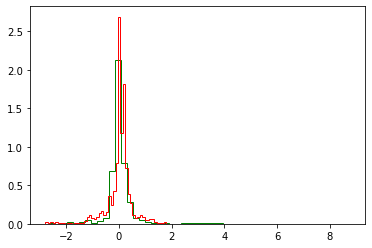

In [4]:
import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()

In [5]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x_in = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_tr = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x_in

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y_pred = tf.matmul(h_fc4_drop, W_fc5) + b_fc5 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Training Model

In [6]:
!pip install -U scikit-image

Requirement already up-to-date: scikit-image in c:\users\hims1\.conda\envs\gputest\lib\site-packages (0.16.2)


In [7]:
LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_tr, y_pred))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={x_in: xs, y_tr: ys, keep_prob: 0.5})
        if i % 10 == 0:
            xs, ys = LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={x_in:xs, y_tr: ys, keep_prob: 0.5})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={x_in:xs, y_tr: ys, keep_prob: 0.5})
    summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    if i % batch_size == 0:
        if not os.path.exists(LOGDIR):
            os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
            print("Model saved in file: %s" % filename)
            
    if (i+1) % batch_size == 0:
        if not os.path.exists(SAVEDIR):
            os.makedirs(SAVEDIR)
        save_path = os.path.join(SAVEDIR, "model.ckpt")
        saver.save(sess = sess, save_path = save_path)
        print("Model saved at location {} at epoch {}".format(save_path, epoch + 1))

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Instructions for updating:
Use `tf.global_variables_initializer` instead.


C:\Users\hims1\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\hims1\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\hims1\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\hims1\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch: 0, Step: 0, Loss: 10.9201
Epoch: 0, Step: 10, Loss: 6.81129
Epoch: 0, Step: 20, Loss: 6.5184
Epoch: 0, Step: 30, Loss: 6.39414
Epoch: 0, Step: 40, Loss: 6.4146
Epoch: 0, Step: 50, Loss: 6.17951
Epoch: 0, Step: 60, Loss: 6.2861
Epoch: 0, Step: 70, Loss: 6.46468
Epoch: 0, Step: 80, Loss: 6.26695
Epoch: 0, Step: 90, Loss: 5.93812
Epoch: 0, Step: 100, Loss: 5.88701
Epoch: 0, Step: 110, Loss: 5.80502
Epoch: 0, Step: 120, Loss: 5.80508
Epoch: 0, Step: 130, Loss: 6.1617
Epoch: 0, Step: 140, Loss: 6.53484
Epoch: 0, Step: 150, Loss: 5.94083
Epoch: 0, Step: 160, Loss: 6.4883
Epoch: 0, Step: 170, Loss: 5.87944
Epoch: 0, Step: 180, Loss: 6.19864
Epoch: 0, Step: 190, Loss: 5.92658
Epoch: 0, Step: 200, Loss: 5.53121
Epoch: 0, Step: 210, Loss: 5.46682
Epoch: 0, Step: 220, Loss: 5.47873
Epoch: 0, Step: 230, Loss: 5.50971
Epoch: 0, Step: 240, Loss: 6.37759
Epoch: 0, Step: 250, Loss: 5.54517
Epoch: 0, Step: 260, Loss: 7.339
Epoch: 0, Step: 270, Loss: 5.85403
Epoch: 0, Step: 280, Loss: 6.41068
Epo

Epoch: 5, Step: 560, Loss: 2.40778
Epoch: 5, Step: 570, Loss: 2.40083
Epoch: 5, Step: 580, Loss: 2.4084
Epoch: 5, Step: 590, Loss: 2.44225
Epoch: 5, Step: 600, Loss: 5.22552
Epoch: 5, Step: 610, Loss: 5.16272
Epoch: 5, Step: 620, Loss: 2.35829
Epoch: 5, Step: 630, Loss: 2.3481
Epoch: 5, Step: 640, Loss: 2.38421
Epoch: 5, Step: 650, Loss: 2.37711
Epoch: 5, Step: 660, Loss: 2.36217
Epoch: 5, Step: 670, Loss: 2.37328
Epoch: 5, Step: 680, Loss: 2.43044
Epoch: 5, Step: 690, Loss: 2.30046
Epoch: 5, Step: 700, Loss: 2.31855
Epoch: 5, Step: 710, Loss: 2.30669
Epoch: 5, Step: 720, Loss: 2.29149
Epoch: 5, Step: 730, Loss: 2.27742
Epoch: 5, Step: 740, Loss: 2.33281
Epoch: 5, Step: 750, Loss: 2.3187
Epoch: 5, Step: 760, Loss: 2.3282
Epoch: 5, Step: 770, Loss: 2.32985
Epoch: 5, Step: 780, Loss: 2.25259
Epoch: 5, Step: 790, Loss: 2.23132
Epoch: 5, Step: 800, Loss: 2.22236
Epoch: 5, Step: 810, Loss: 2.20926
Epoch: 5, Step: 820, Loss: 2.20256
Epoch: 5, Step: 830, Loss: 2.19543
Epoch: 5, Step: 840, Los

Epoch: 10, Step: 1080, Loss: 1.01241
Epoch: 10, Step: 1090, Loss: 1.03245
Epoch: 10, Step: 1100, Loss: 1.03612
Epoch: 10, Step: 1110, Loss: 0.991705
Epoch: 10, Step: 1120, Loss: 1.08238
Epoch: 10, Step: 1130, Loss: 1.36692
Epoch: 10, Step: 1140, Loss: 1.06748
Epoch: 10, Step: 1150, Loss: 1.14716
Epoch: 10, Step: 1160, Loss: 0.969216
Epoch: 10, Step: 1170, Loss: 0.966201
Epoch: 10, Step: 1180, Loss: 0.96027
Epoch: 10, Step: 1190, Loss: 0.957529
Epoch: 10, Step: 1200, Loss: 0.978186
Epoch: 10, Step: 1210, Loss: 5.48654
Epoch: 10, Step: 1220, Loss: 1.85965
Epoch: 10, Step: 1230, Loss: 0.941574
Epoch: 10, Step: 1240, Loss: 0.946644
Epoch: 10, Step: 1250, Loss: 0.957652
Epoch: 10, Step: 1260, Loss: 0.938067
Epoch: 10, Step: 1270, Loss: 0.94762
Epoch: 10, Step: 1280, Loss: 0.977377
Epoch: 10, Step: 1290, Loss: 0.929985
Epoch: 10, Step: 1300, Loss: 0.928106
Epoch: 10, Step: 1310, Loss: 0.938211
Epoch: 10, Step: 1320, Loss: 0.93218
Epoch: 10, Step: 1330, Loss: 0.901893
Epoch: 10, Step: 1340, L

Epoch: 14, Step: 1810, Loss: 0.691535
Epoch: 14, Step: 1820, Loss: 0.398924
Epoch: 14, Step: 1830, Loss: 0.475093
Epoch: 14, Step: 1840, Loss: 0.590675
Epoch: 14, Step: 1850, Loss: 0.544561
Epoch: 15, Step: 1500, Loss: 0.390921
Epoch: 15, Step: 1510, Loss: 0.385618
Epoch: 15, Step: 1520, Loss: 0.363416
Epoch: 15, Step: 1530, Loss: 0.395163
Epoch: 15, Step: 1540, Loss: 0.532367
Epoch: 15, Step: 1550, Loss: 1.03594
Epoch: 15, Step: 1560, Loss: 0.653522
Epoch: 15, Step: 1570, Loss: 1.22948
Epoch: 15, Step: 1580, Loss: 0.677197
Epoch: 15, Step: 1590, Loss: 0.852118
Epoch: 15, Step: 1600, Loss: 0.622649
Epoch: 15, Step: 1610, Loss: 0.354945
Epoch: 15, Step: 1620, Loss: 0.354533
Epoch: 15, Step: 1630, Loss: 0.379246
Epoch: 15, Step: 1640, Loss: 0.453709
Epoch: 15, Step: 1650, Loss: 1.21183
Epoch: 15, Step: 1660, Loss: 0.481863
Epoch: 15, Step: 1670, Loss: 2.13383
Epoch: 15, Step: 1680, Loss: 0.819647
Epoch: 15, Step: 1690, Loss: 1.21451
Epoch: 15, Step: 1700, Loss: 0.511904
Epoch: 15, Step: 

Epoch: 19, Step: 2180, Loss: 0.202954
Epoch: 19, Step: 2190, Loss: 0.319332
Epoch: 19, Step: 2200, Loss: 0.436632
Epoch: 19, Step: 2210, Loss: 0.295458
Epoch: 19, Step: 2220, Loss: 0.312463
Epoch: 19, Step: 2230, Loss: 0.208031
Epoch: 19, Step: 2240, Loss: 0.193495
Epoch: 19, Step: 2250, Loss: 0.19795
Epoch: 19, Step: 2260, Loss: 0.300564
Epoch: 19, Step: 2270, Loss: 0.20896
Epoch: 19, Step: 2280, Loss: 0.218525
Epoch: 19, Step: 2290, Loss: 0.215582
Epoch: 19, Step: 2300, Loss: 0.229545
Epoch: 19, Step: 2310, Loss: 0.211023
Epoch: 19, Step: 2320, Loss: 0.196407
Epoch: 19, Step: 2330, Loss: 0.179001
Epoch: 19, Step: 2340, Loss: 0.173156
Epoch: 19, Step: 2350, Loss: 0.184691
Epoch: 20, Step: 2000, Loss: 0.269477
Epoch: 20, Step: 2010, Loss: 2.66926
Epoch: 20, Step: 2020, Loss: 3.1814
Epoch: 20, Step: 2030, Loss: 0.180999
Epoch: 20, Step: 2040, Loss: 0.170422
Epoch: 20, Step: 2050, Loss: 0.219316
Epoch: 20, Step: 2060, Loss: 0.214738
Epoch: 20, Step: 2070, Loss: 0.212591
Epoch: 20, Step: 

Epoch: 24, Step: 2550, Loss: 0.139437
Epoch: 24, Step: 2560, Loss: 0.149627
Epoch: 24, Step: 2570, Loss: 0.68561
Epoch: 24, Step: 2580, Loss: 1.72759
Epoch: 24, Step: 2590, Loss: 0.297786
Epoch: 24, Step: 2600, Loss: 0.310453
Epoch: 24, Step: 2610, Loss: 0.148698
Epoch: 24, Step: 2620, Loss: 0.307076
Epoch: 24, Step: 2630, Loss: 0.514519
Epoch: 24, Step: 2640, Loss: 0.580294
Epoch: 24, Step: 2650, Loss: 0.893253
Epoch: 24, Step: 2660, Loss: 0.809091
Epoch: 24, Step: 2670, Loss: 0.471758
Epoch: 24, Step: 2680, Loss: 0.225957
Epoch: 24, Step: 2690, Loss: 0.165332
Epoch: 24, Step: 2700, Loss: 0.348097
Epoch: 24, Step: 2710, Loss: 0.464848
Epoch: 24, Step: 2720, Loss: 0.488831
Epoch: 24, Step: 2730, Loss: 0.390975
Epoch: 24, Step: 2740, Loss: 0.24208
Epoch: 24, Step: 2750, Loss: 0.178004
Epoch: 24, Step: 2760, Loss: 0.195333
Epoch: 24, Step: 2770, Loss: 0.223971
Epoch: 24, Step: 2780, Loss: 0.616804
Epoch: 24, Step: 2790, Loss: 1.19492
Epoch: 24, Step: 2800, Loss: 0.30731
Epoch: 24, Step: 

Epoch: 29, Step: 2920, Loss: 0.128433
Epoch: 29, Step: 2930, Loss: 0.176266
Epoch: 29, Step: 2940, Loss: 0.155887
Epoch: 29, Step: 2950, Loss: 0.132643
Epoch: 29, Step: 2960, Loss: 0.152357
Epoch: 29, Step: 2970, Loss: 0.142456
Epoch: 29, Step: 2980, Loss: 0.132061
Epoch: 29, Step: 2990, Loss: 0.12184
Epoch: 29, Step: 3000, Loss: 0.195559
Epoch: 29, Step: 3010, Loss: 0.148731
Epoch: 29, Step: 3020, Loss: 0.201449
Epoch: 29, Step: 3030, Loss: 0.154455
Epoch: 29, Step: 3040, Loss: 0.212159
Epoch: 29, Step: 3050, Loss: 0.158778
Epoch: 29, Step: 3060, Loss: 0.13012
Epoch: 29, Step: 3070, Loss: 0.135449
Epoch: 29, Step: 3080, Loss: 0.13549
Epoch: 29, Step: 3090, Loss: 0.266154
Epoch: 29, Step: 3100, Loss: 2.30551
Epoch: 29, Step: 3110, Loss: 7.89721
Epoch: 29, Step: 3120, Loss: 3.81066
Epoch: 29, Step: 3130, Loss: 0.14655
Epoch: 29, Step: 3140, Loss: 0.132214
Epoch: 29, Step: 3150, Loss: 0.132502
Epoch: 29, Step: 3160, Loss: 0.142655
Epoch: 29, Step: 3170, Loss: 0.132828
Epoch: 29, Step: 31

In [9]:
import os 
os.getcwd()

'C:\\Users\\hims1\\Autopilot-TensorFlow-master\\Autopilot-TensorFlow-master'

In [ ]:
import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

cap = cv2.VideoCapture(0)
while(cv2.waitKey(10) != ord('q')):
    ret, frame = cap.read()
    image = scipy.misc.imresize(frame, [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180 / scipy.pi
    call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow('frame', frame)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)

cap.release()
cv2.destroyAllWindows()


In [1]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5